In [1]:
from astropy.coordinates import SkyCoord
import astropy.table
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import cloudpickle
import pickle
# import pymc as pm
from tqdm import tqdm
import warnings
from scanf import scanf
import copy
import pandas as pd
import sys
import os
import glob

import tessAPP


In [2]:
def get_max_good_sector(toiTevEntry):
    parseStr = ["qlp-s%d-ffi",
           "qlp-s%d-faintsearch",
           "qlp-s%d-tois",
           "qlp-s%d-CTOIs",
           "qlp-s%ds%d",
           "qlp-s%d-",
           "qlp-%d-tois",
           "sector-%d-qlp-alerts",
           "common-s%d",
           "spoc-s%d-s%d-",
           "spoc-s%d-tois",
           "spoc-s%d-b",
           "spoc-s%ds%d-b",
           "spoc-s%d",
           "spoc-%d-b",
           "spoc-%d-s%d-b",
           "spoc-%d-s%d-b",
           "sector-%d-spoc-alerts"]
    
    sectors = None
    sourceStr = toiTevEntry["Parameter Source Pipeline"].values[0]
    for ps in parseStr:
        if scanf(ps, sourceStr) is not None:
            sectors = scanf(ps, sourceStr)
            break
    if sectors is None:
        sectors = [int(i) for i in thisTev["Sectors"].values[0][1:-1].split(', ')]
        
    return max(sectors)


# thisTev = tevTable[tevTable["Full TOI ID"] == 390.01] 
# maxSector = get_max_good_sector(thisTev)
# print([maxSector, thisTev["Parameter Source Pipeline"].values[0], thisTev["Sectors"].values[0]])


def get_good_TOIs(tevTable):
    parseStr = ["spoc-s01-s3",
           "spoc-s01-s4"]
    
    spocTois = []
    for index, toiTevEntry in tevTable.iterrows():
        sectors = None
        sourceStr = toiTevEntry["Parameter Source Pipeline"]
        for ps in parseStr:
            if scanf(ps, sourceStr) is not None:
                sectors = scanf(ps, sourceStr)
                toiDict = {}
                toiDict["toiNum"] = toiTevEntry["Full TOI ID"]
                toiDict["sectors"] = sectors
                spocTois.append(toiDict)
                break
        
    return spocTois


# thisTev = tevTable[tevTable["Full TOI ID"] == 390.01] 
# maxSector = get_max_good_sector(thisTev)
# print([maxSector, thisTev["Parameter Source Pipeline"].values[0], thisTev["Sectors"].values[0]])




In [3]:
outputDir = "appTableProduction/"
completeAppList = []
skippedAppList = []

with os.scandir(outputDir) as it:
    for entry in it:
        if entry.is_dir():
            ff = glob.glob(outputDir + entry.name + "/imageData*sector*.pickle")
            if len(ff) > 0:
                for f in ff:
                    toiNum = float(f.split("/")[2].split("_")[2])
                    if (toiNum in completeAppList) | (toiNum in skippedAppList):
                        continue
                    if os.path.exists(outputDir + entry.name + "/TOI_" + str(toiNum) + "_compareData.pickle"):
                        completeAppList.append(toiNum)
                    else:
                        skippedAppList.append(toiNum)

print("there are " + str(len(completeAppList)) + " completed APP TOIs")

there are 3859 completed APP TOIs


In [4]:
ephemLabels = pd.read_csv("ephem.labels.csv", names = ["toiNum", "label"])
catEphem = []
fitEphem = []
boxEphem = []
handFit = []
noInfo = []
problemPeriod = []
for i, row in ephemLabels.iterrows():
    if row["label"] == "C":
        catEphem.append(row["toiNum"])
    if row["label"] == "F":
        fitEphem.append(row["toiNum"])        
    if row["label"] == "B":
        boxEphem.append(row["toiNum"])        
    if row["label"] == "H":
        handFit.append(row["toiNum"])        
    if row["label"] == "N":
        noInfo.append(row["toiNum"])        
    if row["label"] == "P":
        problemPeriod.append(row["toiNum"])        


In [5]:
print("catEphem: " + str(len(catEphem)))
print("fitEphem: " + str(len(fitEphem)))
print("boxEphem: " + str(len(boxEphem)))
print("handFit: " + str(len(handFit)))
print("noInfo: " + str(len(noInfo)))
print("problemPeriod: " + str(len(problemPeriod)))


catEphem: 4427
fitEphem: 401
boxEphem: 34
handFit: 480
noInfo: 518
problemPeriod: 24


In [6]:
tevTable = pd.read_csv("tev-toi-catalog.csv", comment='#')

In [7]:
toiTable = pd.read_csv("toi_table_tfop.csv")


In [8]:
def set_toi_data(toi, toiTable):
    bjdOffset = 2457000.0

    planetData = {}
    planetData['TOI'] = toi
    planetData['period'] = toiTable['Period (days)'].values[0]
    planetData['epoch'] = toiTable['Epoch (BJD)'].values[0] - bjdOffset
    planetData['durationHours'] = toiTable['Duration (hours)'].values[0]
    planetData['depth'] = toiTable['Depth (ppm)'].values[0]*1e-6
    planetData['rprs'] = np.sqrt(planetData['depth'])

    return planetData

In [9]:
ephemDir = "ephemFits/"
fewSectorTois = []
manySectorTois = []

it = glob.glob(ephemDir + "/*.pickle")
for entry in it:
    toiNum = float(entry.split("/")[1].split("_")[0])
    fewSectorTois.append(toiNum)

it = glob.glob(ephemDir + "/*.png")
for entry in it:
    toiNum = float(entry.split("/")[1].split("_")[0])
    if toiNum not in fewSectorTois:
        manySectorTois.append(toiNum)

print("there are " + str(len(fewSectorTois)) + " few sector TOIs")
print("there are " + str(len(manySectorTois)) + " many sector TOIs")

there are 4281 few sector TOIs
there are 1605 many sector TOIs


In [10]:
vettedTois = list(set(catEphem).union(set(skippedAppList)))
len(vettedTois)

4432

In [11]:
# toisToRun = list(set(vettedTois).intersection(set(fewSectorTois)))
toisToRun = vettedTois
len(toisToRun)

4432

In [12]:
# toisToRun = np.loadtxt("good_spoc_tois.txt")
outputDir = "appTableProduction/" 

In [18]:
plt.ioff()

tooManyStarsFileName = "tooManyStarsEven.npy"
if os.path.exists(tooManyStarsFileName):
    tooManyStarsList = np.load(tooManyStarsFileName)
else:
    tooManyStarsList = np.array([])
    

# for toiNum in toisToRun:
for toiNum in [5803.01]:
#     print("TOI " + str(toiNum))

#     if int(toiNum)%2 == 1:
#         continue

#     if np.isin(toiNum, tooManyStarsList):
#         continue

    thisToi = toiTable[toiTable.TOI == toiNum]

    if thisToi['TESS Mag'].values[0] < 7.5:
        print("TOI " + str(toiNum) + " is saturated")
        continue

    c = SkyCoord(thisToi['RA'].values[0], thisToi['Dec'].values[0], unit=(u.hourangle, u.deg))

    planet0 = {}
    ticCatalogData = {}
    ticCatalogData['id'] = thisToi['TIC ID'].values[0]
    ticCatalogData['raDegrees'] = c.ra.deg
    ticCatalogData['decDegrees'] = c.dec.deg
    ticCatalogData['sector'] = None
    ticCatalogData['cam'] = None
    ticCatalogData['ccd'] = None
    ticCatalogData['starRadius'] = thisToi['Stellar Radius (R_Sun)'].values[0]
    ticCatalogData['TMag'] = thisToi['TESS Mag'].values[0]

    planet0 = set_toi_data(toiNum, thisToi)
#     if os.path.exists(outputDir + "tic" + str(ticCatalogData['id']) + "/TOI_" + str(toiNum) + "_compareData.pickle"):
#         continue
#     if (toiNum in completeAppList) | (toiNum in skippedAppList):
#     if (toiNum in completeAppList):
#         continue


    ticCatalogData["planetData"] = [planet0]

    # find other TOIs on this star
    otherToi = toiTable[(toiTable.TOI.astype(int) == int(toiNum)) & (toiTable.TOI != toiNum)]
    otherToi.TOI.values
    for t in otherToi.TOI.values:
        thisOtherToi = toiTable[toiTable.TOI == t]
        ticCatalogData["planetData"].append(set_toi_data(t, thisOtherToi))

    ticName = "tic" + str(ticCatalogData["id"])
    toiName = ticName + "/TOI_" + str(toiNum)
    display(ticCatalogData)
    continue
    ticData = copy.deepcopy(ticCatalogData)

#     try:
    tapp = tessAPP.tessAPP(ticData,
                outputDir = outputDir,
                usePyMC3 = False,
                spiceFileLocation = "../TESS-plots/",
                qlpFlagsLocation = "../QLP_qflags/",
                cleanFiles = False)
    tapp.make_difference_images()
    tapp.find_transiting_sectors()
    if len(tapp.transitingSectors) == 0:
        print("TOI " + str(toiNum) + ": no transiting sectors")
        continue
    tapp.find_possible_background_stars()
    if len(tapp.selectedStars) > 50:
        print("too many stars to check")
        tooManyStarsList = np.append(tooManyStarsList, toiNum)
        np.save(tooManyStarsFileName, tooManyStarsList)
        continue
    tapp.collect_sectors()
    tapp.compute_app()
    tapp.draw()
#     except KeyboardInterrupt:
#         print('Interrupted')
#         try:
#             sys.exit(0)
#         except SystemExit:
#             os._exit(0)
#     except:
#         print("something went wrong, moving on")




{'id': 466382581,
 'raDegrees': 327.24875,
 'decDegrees': 6.278177777777778,
 'sector': None,
 'cam': None,
 'ccd': None,
 'starRadius': 0.76,
 'TMag': 9.937,
 'planetData': [{'TOI': 5803.01,
   'period': 5.3834388,
   'epoch': 2818.861117000226,
   'durationHours': 1.247,
   'depth': 0.00172,
   'rprs': 0.04147288270665544}]}

In [14]:
max(toisToRun)

6008.01

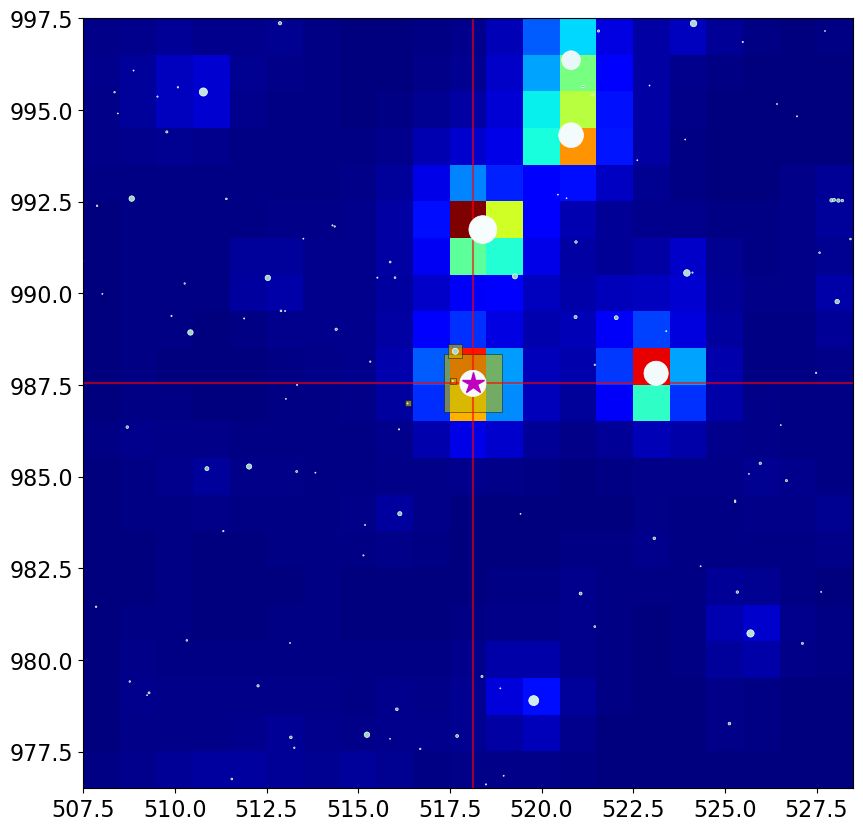

In [15]:
plt.figure(figsize=(10,10))
tapp.tdi.draw_pix_catalog(tapp.sectorData.diffImageData["meanOutTransit"],
                     tapp.sectorData.catalogData,
                     extent=tapp.sectorData.catalogData["extent"],
                     close=False, annotate=False, dMagThreshold = 6,
                     magColorBar=False, pixColorBar=False, hiliteStar = tapp.closeEnoughStars)


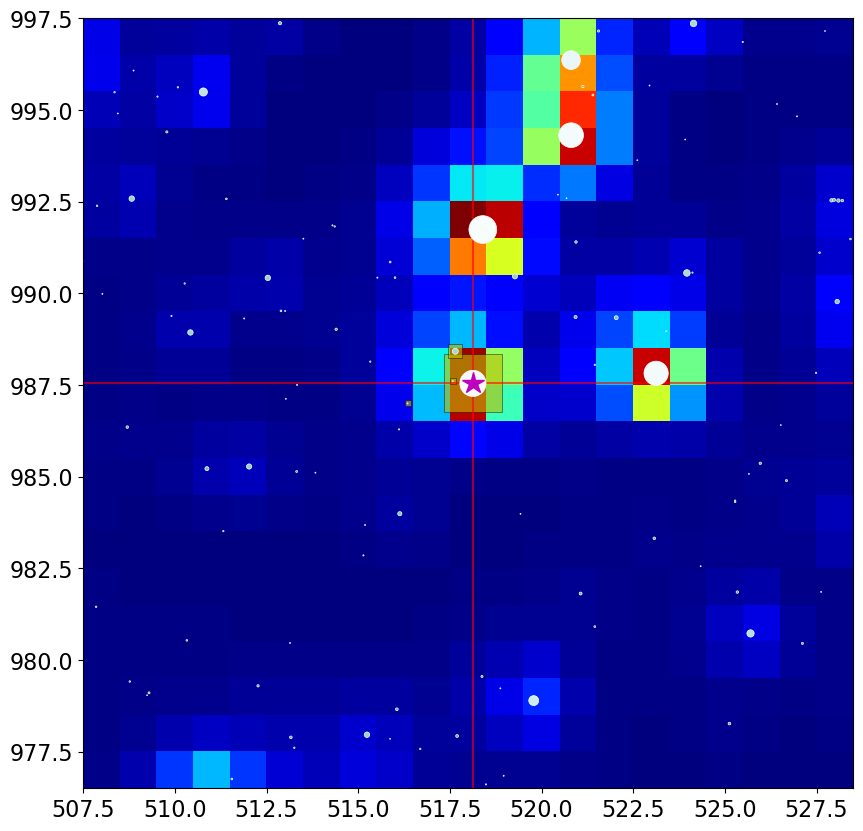

In [16]:
simImage = tapp.sectorData.make_simulated_image(useLarge=True)
plt.figure(figsize=(10,10))
tapp.tdi.draw_pix_catalog(simImage,
                     tapp.sectorData.catalogData,
                     extent=tapp.sectorData.catalogData["extent"],
                     close=False, annotate=False, dMagThreshold = 6,
                     magColorBar=False, pixColorBar=False, hiliteStar = tapp.closeEnoughStars)
